In [ ]:
"""
Purpose: To improve the crossover function so it has more correct pairings made


The false crossover will just depend on downstream skeleton length
- need to fend off against the potential spines causing high degree nodes


"""

In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")
sys.path.append("/meshAfterParty/meshAfterParty")

import datajoint_utils as du
from importlib import reload

INFO - 2021-04-23 15:09:31,432 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-04-23 15:09:31,435 - settings - Setting database.user to celiib
INFO - 2021-04-23 15:09:31,435 - settings - Setting database.password to newceliipass
INFO - 2021-04-23 15:09:31,481 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2021-04-23 15:09:31,483 - settings - Setting enable_python_native_blobs to True
INFO - 2021-04-23 15:09:31,498 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-04-23 15:09:31,935 - settings - Setting enable_python_native_blobs to True
INFO - 2021-04-23 15:09:31,959 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-04-23 15:09:31,960 - settings - Setting database.user to celiib
INFO - 2021-04-23 15:09:31,961 - settings - Setting database.password to newceliipass
INFO - 2021-04-23 15:09:31,962 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-04-23 15:09:31,963 - settings - Setting database.user to celiib
INFO - 2021-04-23 15:09:31,964 - settings - Setting database.password to newceliipass
INFO - 2021-04-23 15:09:31,965 - settings - Setting enable_python_native_blobs to True
INFO - 2021-04-23 15:09:32,425 - settings - Setting enable_python_native_blobs to True


In [3]:
#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-04-23 15:09:33,711 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-04-23 15:09:33,713 - settings - Setting database.user to celiib
INFO - 2021-04-23 15:09:33,715 - settings - Setting database.password to newceliipass
INFO - 2021-04-23 15:09:33,719 - settings - Setting enable_python_native_blobs to True
INFO - 2021-04-23 15:09:34,233 - settings - Setting enable_python_native_blobs to True


In [4]:
import validation_utils as vu
import neuron_visualizations as nviz
import neuron_utils as nru

# Downloading the Neuron

In [6]:
segment_id = 864691136194042326
minnie.Decomposition() & f"segment_id = {segment_id}"

segment_id segment id unique within each Segmentation,decimation_version,decimation_ratio ratio of remaining mesh vertices/faces (which ones depends on what metric the decimation technique uses),ver the version number of the materializaiton,process_version the version of the preprocessing pipeline run,index the index of the neuron object that resulted from that mesh (indexed starting at 0),multiplicity the number of somas found for this base segment,decomposition,n_vertices number of vertices,n_faces number of faces,n_not_processed_soma_containing_meshes the number of meshes with somas that were not processed,n_error_limbs the number of limbs that are touching multiple somas or 1 soma in multiple places,n_same_soma_multi_touching_limbs number of limbs that touch the same soma multiple times,n_multi_soma_touching_limbs number of limbs that touch multiple somas,n_somas number of soma meshes detected,n_limbs,n_branches,max_limb_n_branches,skeletal_length,max_limb_skeletal_length,median_branch_length gives information on average skeletal length to next branch point,width_median median width from mesh center without spines removed,width_no_spine_median median width from mesh center with spines removed,width_90_perc 90th percentile for width without spines removed,width_no_spine_90_perc 90th percentile for width with spines removed,n_spines,spine_density n_spines/ skeletal_length,spines_per_branch,skeletal_length_eligible the skeletal length for all branches searched for spines,n_spine_eligible_branches the number of branches that were checked for spines because passed width threshold,spine_density_eligible n_spines/skeletal_length_eligible,spines_per_branch_eligible n_spines/n_spine_eligible_branches,total_spine_volume the sum of all spine volume,spine_volume_median median of the spine volume for those spines with able to calculate volume,spine_volume_density total_spine_volume/skeletal_length,spine_volume_density_eligible total_spine_volume/skeletal_length_eligible,spine_volume_per_branch_eligible total_spine_volume/n_spine_eligible_branches,run_time the amount of time to run (seconds)
864691136194042326,0,0.25,30.00,7,0,1,=BLOB=,543348,1100473,0,0,0,0,1,5,134,92,5711902.431454649,3489105.382868428,24117.997,87.607,87.607,543.496,482.187,1643,0.00028764496938046916,12.261194029850746,3062061.696,52,0.0005365665891534016,31.596,495451480854.54834,172336953.29870287,86740.18626896814,161803.232606894,9527913093.356699,5274.2019


In [7]:
restriction_dict = dict(segment_id=segment_id)
neuron_obj = (minnie.AutoProofreadValidationBorderNeurons() & restriction_dict).fetch1("decomposition")

Decompressing Neuron in minimal output mode...please wait


In [69]:
nviz.plot_axon(neuron_obj)


 Working on visualization type: mesh

 Working on visualization type: skeleton


In [30]:
limb_obj = neuron_obj[neuron_obj.axon_limb_name]

In [32]:
exactly_equal = True
crossover_coordinates = nru.high_degree_branching_coordinates_on_limb(limb_obj,min_degree_to_find=4,
                                                                         exactly_equal=exactly_equal,
                                                                         )
crossover_coordinates

array([[633369.46396577, 642628.37375774, 904286.15810562],
       [655835.01357908, 654071.79933467, 886661.69334533],
       [703150.15902442, 700224.74801046, 786377.94326672],
       [705796.38338002, 711368.54932521, 761452.07011226],
       [711853.1830047 , 552176.20588093, 767067.14412926],
       [719501.00551068, 601977.08581794, 840192.81639721],
       [719805.70771174, 679693.9415088 , 844847.81574894],
       [720981.3       , 562902.3       , 765358.2       ],
       [728999.61952349, 582089.64207094, 768015.20907531],
       [733771.5       , 548121.        , 740360.2       ],
       [736772.19569597, 611850.46123094, 775357.26609334],
       [743911.0929221 , 628175.96933381, 780234.59592461],
       [750591.55787221, 617483.44533858, 774418.16749602],
       [757709.        , 627037.        , 883750.        ],
       [764716.17668896, 550429.59903124, 756843.11309073],
       [778997.63860834, 575057.52431717, 763678.03793613]])

In [36]:
coordinate = crossover_coordinates[0]
nru.find_branch_with_specific_coordinate(limb_obj,coordinate)

array([5, 7, 8, 9])

In [68]:
import error_detection as ed
ed.matched_branches_by_angle_at_coordinate(limb_obj,
                                        coordinate,
                                        offset=1500,
                                        #offset=2000,
                                        comparison_distance = 2500,
                                        match_threshold = 40,
                                        verbose = True,
                                        plot_intermediates = True,
                                        plot_match_intermediates = True)

coordinate_branches = [5, 7, 8, 9]
5 = red
7 = aqua
8 = purple
9 = green


Angle between 5 and 7 = 132.47 
Angle between 5 and 8 = 56.52 
Angle between 5 and 9 = 8.75 
Angle between 7 and 8 = 103.95 
Angle between 7 and 9 = 48.68 
Angle between 8 and 9 = 122.91 
Final Matches = [[5, 9]], Final Matches Angle = [8.75]
Aligned Skeleton Parts


([[5, 9]], [8.75])

# Trying Crossover Filter Without Improvements

In [164]:
pru = reload(pru)
pru.v4_exc_filters()

[{'filter_name': 'axon_on_dendrite_merges',
  'filter_function': <function proofreading_utils.filter_away_axon_on_dendrite_merges(neuron_obj, perform_deepcopy=True, axon_merge_error_limb_branch_dict=None, perform_axon_classification=False, use_pre_existing_axon_labels=False, return_error_info=True, plot_limb_branch_filter_away=False, plot_limb_branch_filter_with_disconnect_effect=False, plot_final_neuron=False, verbose=False, **kwargs)>,
  'filter_kwargs': {'use_pre_existing_axon_labels': True},
  'catch_error': False},
 {'filter_name': 'crossovers',
  'filter_function': <function proofreading_utils.filter_away_crossovers(neuron_obj, return_error_info=False, plot_limb_branch_filter_with_disconnect_effect=False, plot_limb_branch_filter_away=False, plot_final_neuron=False, **kwargs)>,
  'filter_kwargs': {'axon_dependent': True,
   'match_threshold': 30,
   'comparison_distance': 2500,
   'offset': 2000},
  'catch_error': False}]

In [181]:
limb_branch_dict_to_cancel = {'L0': [258, 259, 260, 261, 262, 263, 241, 242, 245, 246, 250, 251, 254, 255, 10, 11, 12, 14, 15, 16, 17, 18, 44, 46, 66, 54, 55, 57, 58, 59, 215, 39, 40, 208, 209, 210, 211, 23, 21, 22, 183, 212, 213, 186, 187, 214, 30, 31, 34, 35, 101, 103, 72, 13, 78, 143, 79, 145, 148, 86, 87, 89, 91]}

In [180]:
import proofreading_utils as pru
(filt_neuron,
 return_synapse_df_revised,
return_validation_df_revised) =  vu.filtered_neuron_score(neuron_obj = neuron_obj,   
                        filter_list = pru.v4_exc_filters(),
                        verbose = True,
                        plot_score=False)


--- Working on filter 0:
function = crossovers
function __name__ = filter_away_crossovers
function arguments = {'axon_dependent': True, 'match_threshold': 30, 'comparison_distance': 2500, 'offset': 2000}


limb_branch_dict_to_cancel = {'L0': [258, 259, 260, 261, 262, 263, 241, 242, 245, 246, 250, 251, 254, 255, 10, 11, 12, 14, 15, 16, 17, 18, 44, 46, 66, 54, 55, 57, 58, 59, 215, 39, 40, 208, 209, 210, 211, 23, 21, 22, 183, 212, 213, 186, 187, 214, 30, 31, 34, 35, 101, 103, 72, 13, 78, 143, 79, 145, 148, 86, 87, 89, 91]}


Branches Requested to Remove (WITH disconnect effect)

 Working on visualization type: mesh





 ---- Total time for applying filter: 30.682600259780884 -----

--- Finished Part 1: Filtering Neuron -----
Apply the presyn non_error
For presyn: # valid synapses = 172, # error synapses  = 249, # error presyns = 153
For postsyn: # valid synapses = 3028, # error synapses  = 3, # error presyns = 0

--- Finished Part 2: Filtering Synapses -----
Synapsse Results:
Total Number of Synapses = 3452
n_valid_syn_ids_presyn = 172
n_errored_syn_ids_presyn = 249
n_valid_syn_ids_postsyn = 3028
n_errored_syn_ids_postsyn = 3

--- Finished Part 3: Generating Validation Dataframe -----


Segment Id = 864691136194042326
Postsyn counts:
TP:2982
TN:6
FP:26
FN:17
Presyn counts:
TP:68
TN:223
FP:104
FN:1


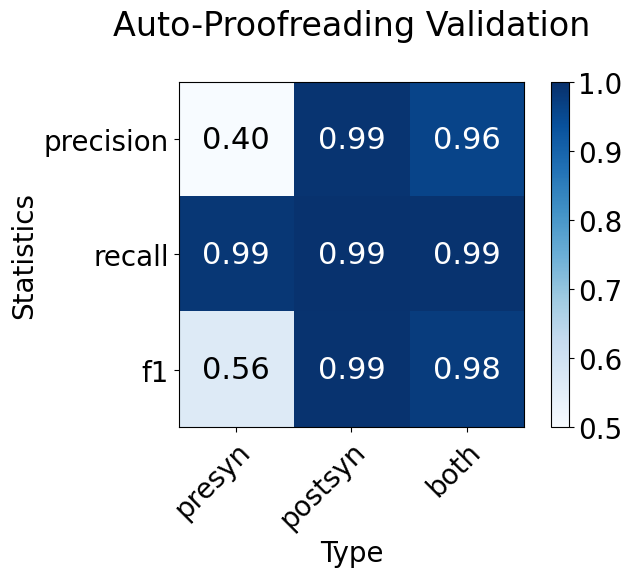

In [166]:
vu.synapse_validation_df_to_score_plot(return_validation_df_revised)

# Visualize the high degree nodes

limb_name = L0

 Working on visualization type: mesh

 Working on visualization type: skeleton


No limb name was given so using L0 because was the limb in the first key


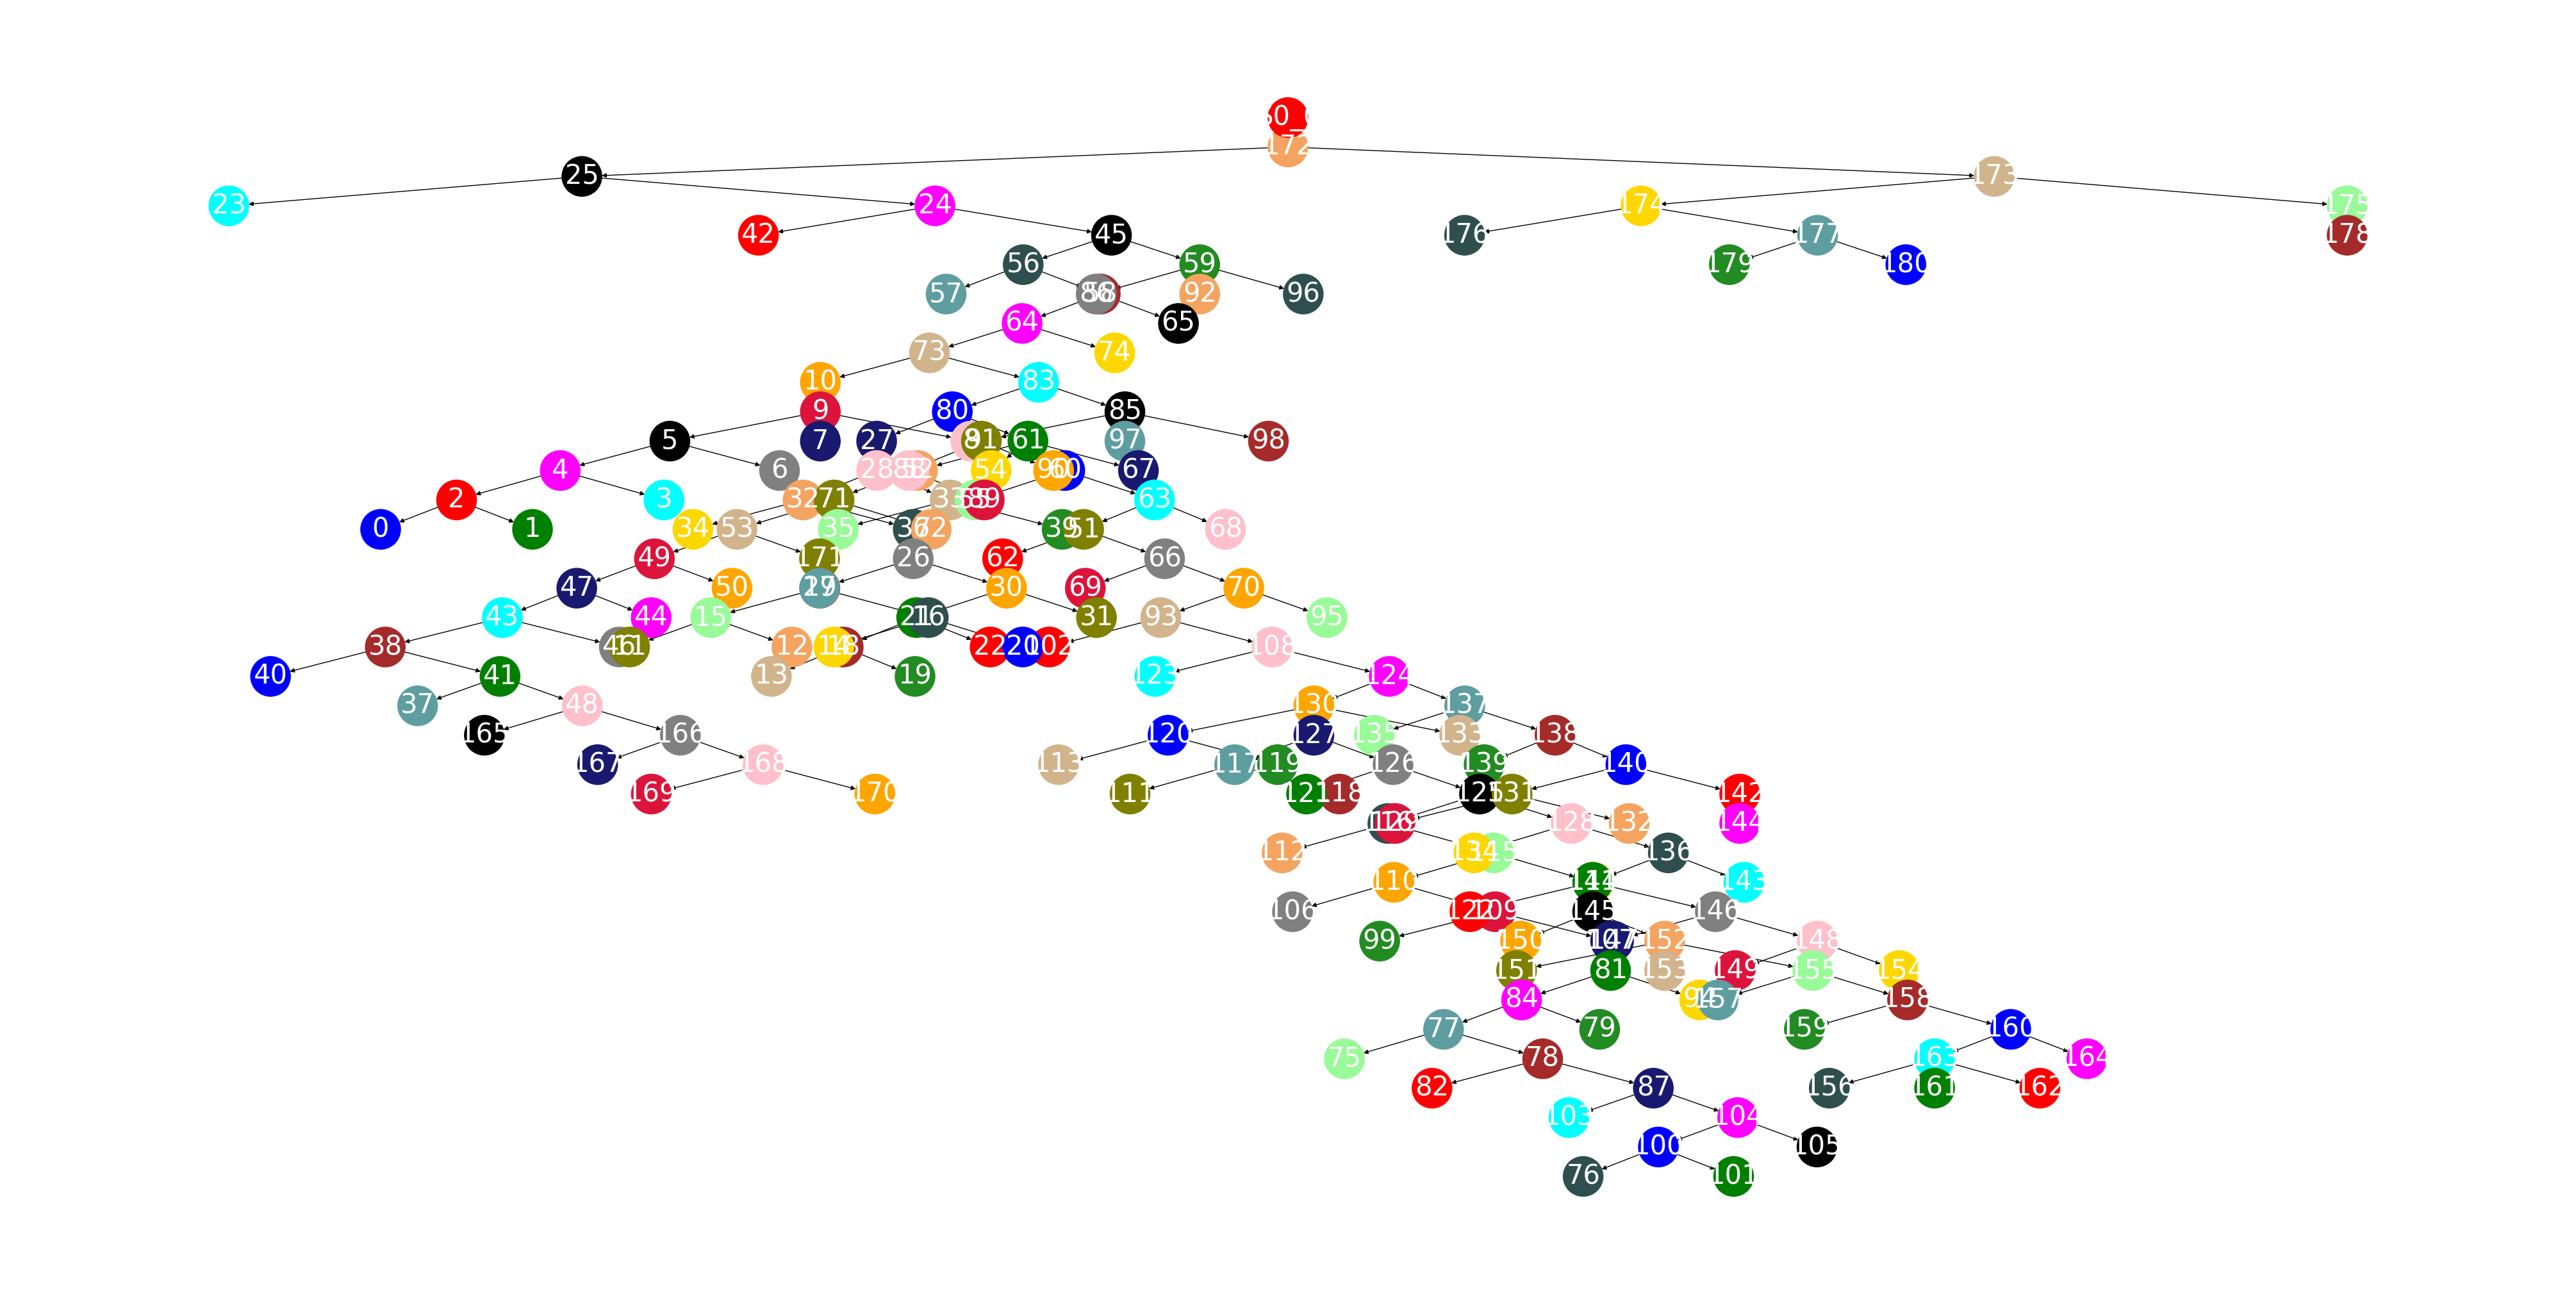

In [142]:
nviz.visualize_neuron_specific_limb(filt_neuron,
                                   0)

In [158]:
nviz.visualize_neuron(filt_neuron,
                     limb_branch_dict="axon")


 Working on visualization type: mesh

 Working on visualization type: skeleton


In [174]:
filt_neuron[0][9].labels

['axon-like', 'axon']

In [167]:
exactly_equal = True
axon_limb_obj = filt_neuron[filt_neuron.axon_limb_name]
crossover_coordinates = nru.high_degree_branching_coordinates_on_limb(axon_limb_obj
                                                                      ,min_degree_to_find=4,
                                                                         exactly_equal=False,
                                                                         )
crossover_coordinates

array([[633369.46396577, 642628.37375774, 904286.15810562],
       [713252.41248611, 668208.00353725, 834130.63609803],
       [719501.00551068, 601977.08581794, 840192.81639721],
       [719805.70771174, 679693.9415088 , 844847.81574894],
       [728999.61952349, 582089.64207094, 768015.20907531],
       [736772.19569597, 611850.46123094, 775357.26609334],
       [743911.0929221 , 628175.96933381, 780234.59592461],
       [750591.55787221, 617483.44533858, 774418.16749602]])

# Debugging why a 4 node made it past

In [ ]:
filter_away_crossovers
crossover_elimination_limb_branch_dict
edges_to_create_and_delete_crossover

In [176]:
coordinate = crossover_coordinates[0]
coordinate

array([633369.46396577, 642628.37375774, 904286.15810562])

In [169]:
nru.find_branch_with_specific_coordinate(axon_limb_obj,
                                        coordinate)

array([5, 7, 8, 9])

In [162]:
nviz.set_zoom(center_coordinate=coordinate,
             radius = 5000)

# Trying how the crossover coordinates are process in the original neuron

In [183]:
crossover_coordinates

array([[633369.46396577, 642628.37375774, 904286.15810562],
       [655835.01357908, 654071.79933467, 886661.69334533],
       [703150.15902442, 700224.74801046, 786377.94326672],
       [705796.38338002, 711368.54932521, 761452.07011226],
       [711853.1830047 , 552176.20588093, 767067.14412926],
       [713252.41248611, 668208.00353725, 834130.63609803],
       [719501.00551068, 601977.08581794, 840192.81639721],
       [719805.70771174, 679693.9415088 , 844847.81574894],
       [720981.3       , 562902.3       , 765358.2       ],
       [728999.61952349, 582089.64207094, 768015.20907531],
       [733771.5       , 548121.        , 740360.2       ],
       [736772.19569597, 611850.46123094, 775357.26609334],
       [743911.0929221 , 628175.96933381, 780234.59592461],
       [750591.55787221, 617483.44533858, 774418.16749602],
       [757709.        , 627037.        , 883750.        ],
       [764716.17668896, 550429.59903124, 756843.11309073],
       [778454.85295756, 579963.51230716

In [192]:
nviz.visualize_neuron_path?

In [213]:
nviz.visualize_neuron_path(neuron_obj,0,[237, 240, 241, 242])


 Working on visualization type: mesh

 Working on visualization type: skeleton


In [214]:
exactly_equal = True
axon_limb_obj = neuron_obj[neuron_obj.axon_limb_name]
crossover_coordinates = nru.high_degree_branching_coordinates_on_limb(axon_limb_obj
                                                                      ,min_degree_to_find=4,
                                                                         exactly_equal=True,
                                                                         )
coordinate = crossover_coordinates[16]

ed.resolving_crossovers(axon_limb_obj,
                        coordinate,
                        match_threshold = 45,
                        verbose = True,
                         return_new_edges = True,
                        return_subgraph=False,
                        plot_intermediates=True,
                         offset=2000,
                         comparison_distance = 2500,
                         best_singular_match=False,
                         lowest_angle_sum_for_pairs=True,
                         return_existing_edges = True)

IndexError: index 16 is out of bounds for axis 0 with size 16

In [219]:
[k for k in dir(nru) if "downstream" in k]

['all_downstream_branches',
 'skeletal_length_over_downstream_branches',
 'skeleton_coordinate_connecting_to_downstream_branches']

In [224]:

xu.upstream_node(axon_limb_obj.concept_network_directional,16)
children_downstream_skeletal_lengths(axon_limb_obj,
                                    branch_idx = 18,
                                    verbose = True)

return_dict = {16: 27236.006834233816, 17: 6697.947930574789}


{16: 27236.006834233816, 17: 6697.947930574789}

In [228]:
import neuron_statistics as nst
nst.children_downstream_skeletal_lengths_min(axon_limb_obj,
                                            18)

6697.947930574789

# Try the mesh t erroring

In [234]:
web_errors_dict = ed.webbing_t_errors_limb_branch_dict(neuron_obj,
                                                      child_skeletal_threshold=5000)

two_downstream_thin_axon_limb_branch = {'L0': array([ 14,  18,  37,  58,  79, 112, 144, 158, 162, 165, 174, 184, 185,
       189, 199, 201])}
wide_angled_children= {'L0': array([ 18, 162, 165])}
Web size = 64.84036663899752
From limb L0, branch 18, Adding the downstream nodes [16, 17]  
Web size = 237.799984874784
Web size = 86.08790745315055
From limb L0, branch 165, Adding the downstream nodes [155, 164]  
Final web t error limb branch dict = {'L0': [16, 17, 155, 164]}


In [231]:
nviz.visualize_neuron(neuron_obj,
                     limb_branch_dict=web_errors_dict,
                     mesh_whole_neuron=True)


 Working on visualization type: mesh

 Working on visualization type: skeleton


In [123]:
import error_detection as ed
ed.matched_branches_by_angle_at_coordinate(axon_limb_obj,
                                        coordinate,
                                        offset=2000,
                                        #offset=2000,
                                        comparison_distance = 2500,
                                        match_threshold = 40,
                                        verbose = True,
                                        plot_intermediates = True,
                                        plot_match_intermediates = True)

coordinate_branches = [52, 54, 60, 61, 67]
52 = blue
54 = green
60 = red
61 = cyan
67 = magenta


Angle between 52 and 54 = 76.99 
Angle between 52 and 60 = 126.26 
Angle between 52 and 61 = 65.83 
Angle between 52 and 67 = 109.89 
Angle between 54 and 60 = 31.77 
Angle between 54 and 61 = 159.59 
Angle between 54 and 67 = 11.39 
Angle between 60 and 61 = 38.08 
Angle between 60 and 67 = 159.19 
Angle between 61 and 67 = 25.84 
Final Matches = [[54, 60], [54, 67], [60, 61], [61, 67]], Final Matches Angle = [31.77, 11.39, 38.08, 25.84]
Aligned Skeleton Parts


([[54, 60], [54, 67], [60, 61], [61, 67]], [31.77, 11.39, 38.08, 25.84])

In [ ]:
"""
Conclusion: Make the offset and comparison much larger
so the bumps at crossovers is avoided
"""

In [ ]:
"""
Observations: For high degree nodes, if there are 2 nodes that
- width is about equal
- all others are end nodes (and not of certain length)

"""